In [1]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import medfilt
import pywt
from ecgdetectors import Detectors
from scipy.signal import resample_poly
import csv

In [2]:
scd_data = {
     './data/scddb/30': '07:54:33',
     './data/scddb/31': '13:42:24',
     './data/scddb/32': '16:45:18',
     './data/scddb/33': '04:46:19',
     './data/scddb/34': '06:35:44',
     './data/scddb/35': '24:34:56',
     './data/scddb/36': '18:59:01',
     './data/scddb/37': '01:31:13',
     './data/scddb/38': '08:01:54',
     './data/scddb/39': '04:37:51',
     #'./data/scddb/40': '00:00:00', # paced, no VF
     './data/scddb/41': '02:59:24', # not working properly
     #'./data/scddb/42': '00:00:00', # no VF
     './data/scddb/43': '15:37:11',
     './data/scddb/44': '19:38:45',
     './data/scddb/45': '18:09:17',
     './data/scddb/46': '03:41:47',
     './data/scddb/47': '06:13:01',
     './data/scddb/48': '02:29:40',
     #'./data/scddb/49': '00:00:00', # paced, no VF
     './data/scddb/50': '11:45:43',
     './data/scddb/51': '22:58:23',
     './data/scddb/52': '02:32:40' # not working properly
}

In [3]:
# H:M:S to seconds
def hms_to_seconds(hms):
    h, m, s = hms.split(':')
    return int(h)*3600 + int(m)*60 + int(s)

In [4]:
def extract_before_onset_VF(vfon_dict, minutes_before=60, fs=250):
    ecg_data_map = {} 

    for record_path, vf_onset_str in vfon_dict.items():
        # record_path might be '.data/scddb/30'
        record_dir, record_name = os.path.split(record_path)

        # 2) Convert dictionary's VF onset to seconds
        vf_onset_original_sec = hms_to_seconds(vf_onset_str)

        vfon_onset_original_sample = vf_onset_original_sec * fs

        seg_len_samples = int(minutes_before * 60 * fs)

        start_sample = vfon_onset_original_sample - seg_len_samples

         # read .dat between those sample indices
        try:
            #record_dat_path = os.path.join(record_dir, record_name)  # base path
            record_path_dat = os.path.join(record_dir, record_name)
            segment = wfdb.rdrecord(record_path_dat, sampfrom=start_sample, sampto=vfon_onset_original_sample)
            
        except Exception as e:
            print(f"[ERROR] Failed to read record {record_dat_path}: {e}")
            continue

        # Retrieve the raw signal data as a NumPy array
        if segment.p_signal is not None:
            arr = segment.p_signal[:,0]
            ecg_data_map[record_name] = arr
            print(f"[OK] Extracted 60-min for {record_name}: shape={arr.shape}")
        else:
            print(f"[WARNING] No p_signal found for {record_name}")

    return ecg_data_map

In [5]:
def segment_ecg(ecg_segment, segment_duration_sec=600, fs=250):
    samples_per_segment = segment_duration_sec * fs
    segments = np.array_split(ecg_segment, len(ecg_segment) // samples_per_segment)
    return segments

In [6]:
def resample_ecg(ecg_signal, orig_fs, target_fs):
    """
    Resample ECG signal from orig_fs to target_fs using polyphase filtering.
    ecg_signal: 1D (or 2D) numpy array (samples x channels)
    """
    # For example, if orig_fs=250, target_fs=128:
    # up = 128, down = 250
    up = target_fs
    down = orig_fs

    if ecg_signal.ndim == 1:
        ecg_resampled = resample_poly(ecg_signal, up, down)
    else:
        # If multi-channel, resample each column
        ecg_resampled = np.array([
            resample_poly(ecg_signal[:, ch], up, down) 
            for ch in range(ecg_signal.shape[1])
        ]).T

    return ecg_resampled

In [7]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = pywt.wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y 

In [8]:
def r_peak_finder(ecg_sig):
    BASIC_SRATE = 128
    signal_pad_samples = 10
    signal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks
    scd_30_denoised_ = ...  # Your denoised 30-min ECG segment
    
    # Initialize the detectors at the given sampling rate
    detector_obj = Detectors(BASIC_SRATE)
    
    # Dictionary of detector functions
    detectors = {
        'pan_tompkins_detector': detector_obj.pan_tompkins_detector,
        'hamilton_detector': detector_obj.hamilton_detector,
        'christov_detector': detector_obj.christov_detector,
        'engzee_detector': detector_obj.engzee_detector,
        'swt_detector': detector_obj.swt_detector,
        'two_average_detector': detector_obj.two_average_detector,
    }
    
    r_peaks = np.array(detector_obj.swt_detector(np.hstack((signal_pad, ecg_sig)) )) - signal_pad_samples
    return r_peaks

In [9]:
def compute_hrv_features(r_peaks, fs=128):
    """
    Time-domain HRV features from R-peaks.
    Returns a dict with:
      MeanRR, RMSDD, pNN50, SDRR, CVRR, NN50, MinRR, MaxRR
    """
    features = {
        'MeanRR': 0.0,
        'RMSDD': 0.0,
        'MADRR': 0.0,
        'MCVNN': 0.0,
        'pNN20': 0.0,
        'pNN50': 0.0,
        'SDRR': 0.0,
        'CVRR': 0.0,
        'NN20': 0,
        'NN50': 0,
        'MinRR': 0.0,
        'MaxRR': 0.0
    }

    rr_samples = np.diff(r_peaks)
    rr_ms = (rr_samples / fs) * 1000.0  # convert to ms

    mean_rr = np.mean(rr_ms)
    sdrr = np.std(rr_ms, ddof=1) if len(rr_ms) > 1 else 0.0
    min_rr = np.min(rr_ms)
    max_rr = np.max(rr_ms)

    rr_diffs = np.diff(rr_ms)
    rmssd = np.sqrt(np.mean(rr_diffs**2)) if len(rr_diffs) > 0 else 0.0
    nn50 = np.sum(np.abs(rr_diffs) > 50)
    pnn50 = (nn50 / len(rr_diffs)) * 100 if len(rr_diffs) > 0 else 0.0
    nn20 = np.sum(np.abs(rr_diffs) > 20)
    pnn20 = (nn20 / len(rr_diffs)) * 100 if len(rr_diffs) > 0 else 0.0
    cvrr = (sdrr / mean_rr * 100.0) if mean_rr else 0.0
    madrr = np.median(np.abs(rr_ms - np.median(rr_ms)))
    mcvnn = np.abs(rr_samples).mean()

    features['MeanRR'] = mean_rr / 1000.0
    features['RMSDD'] = rmssd / 1000.0
    # new 
    features['MADRR'] = madrr / 1000.0
    features['MCVNN'] = mcvnn / 1000.0 
    features['pNN20'] = pnn20 / 1000.0
    
    
    features['pNN50'] = pnn50 / 1000.0
    features['SDRR'] = sdrr / 1000.0
    features['CVRR'] = cvrr / 1000.0 
    # new
    features['NN20'] = nn20 / 1000.0
    
    features['NN50'] = nn50 / 1000.0
    features['MinRR'] = min_rr / 1000.0 
    features['MaxRR'] = max_rr / 1000.0
    
    return features

In [10]:
label_map = ["First", "Second", "Third", "Fourth", "Fifth", "Sixth"]

def save_hrv_to_csv(features_dict, csv_path):
    """
    Save a single row of features_dict into a CSV at csv_path.
    Overwrites if file exists.
    Columns: [MeanRR, RMSDD, MADRR, MCVNN, pNN20, pNN50, SDRR, CVRR, NN20, NN50, MinRR, MaxRR]
    """
    columns = ["MeanRR", "RMSDD", "MADRR", "MCVNN", "pNN20", "pNN50", "SDRR", "CVRR", "NN20", "NN50", "MinRR", "MaxRR"]
    with open(csv_path, mode='w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=columns)
        writer.writeheader()
        writer.writerow({col: features_dict[col] for col in columns})
    print(f"  -> Saved HRV features to {csv_path}")

In [11]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

In [12]:
fs = 128
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(fs,ms_flt_array[i])

In [13]:
def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0,mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

In [14]:
onsetVF_60min_scd = extract_before_onset_VF(scd_data, minutes_before=60, fs=250)

[OK] Extracted 60-min for 30: shape=(900000,)
[OK] Extracted 60-min for 31: shape=(900000,)
[OK] Extracted 60-min for 32: shape=(900000,)
[OK] Extracted 60-min for 33: shape=(900000,)
[OK] Extracted 60-min for 34: shape=(900000,)
[OK] Extracted 60-min for 35: shape=(900000,)
[OK] Extracted 60-min for 36: shape=(900000,)
[OK] Extracted 60-min for 37: shape=(900000,)
[OK] Extracted 60-min for 38: shape=(900000,)
[OK] Extracted 60-min for 39: shape=(900000,)
[OK] Extracted 60-min for 41: shape=(900000,)
[OK] Extracted 60-min for 43: shape=(900000,)
[OK] Extracted 60-min for 44: shape=(900000,)
[OK] Extracted 60-min for 45: shape=(900000,)
[OK] Extracted 60-min for 46: shape=(900000,)
[OK] Extracted 60-min for 47: shape=(900000,)
[OK] Extracted 60-min for 48: shape=(900000,)
[OK] Extracted 60-min for 50: shape=(900000,)
[OK] Extracted 60-min for 51: shape=(900000,)
[OK] Extracted 60-min for 52: shape=(900000,)


In [34]:
scd_segments = {}
for key, value in onsetVF_60min_scd.items():
    scd_segments[key] = segment_ecg(value)

In [36]:
output_dir_scd = "SCD_Features_CSV_1h_10min_segments-test-baseline-wander"
os.makedirs(output_dir_scd, exist_ok=True)

In [40]:
for subj_id, seg_list in scd_segments.items():
    print(f"\nProcessing SCD subject {subj_id}...")
    # seg_list[0] = earliest, seg_list[5] = last
    # We want to label them in REVERSE order:
    #   i=0 => seg_list[5], name: "First 5 mins before SCD"
    #   i=1 => seg_list[4], name: "Second 5 mins before SCD"
    #   ...
    #   i=5 => seg_list[0], name: "Sixth 5 mins before SCD"
    for i in range(6):
        segment_idx = 5 - i  # reversed index
        segment_label = f"SCD_{subj_id}_{label_map[i]}_10_mins_before_SCD"  # e.g. "First_5_mins_before_SCD"
        ecg_signal = seg_list[segment_idx]


        downsampled = resample_ecg(ecg_signal, 250, 128)
        filtered = filter_signal(downsampled)
        denoised_signal = denoise_signal(filtered, 'sym20', 8, -5 , 5)

            
        # 1) Detect R-peaks
        r_peaks = r_peak_finder(denoised_signal)
        
        # 2) Compute HRV
        feats = compute_hrv_features(r_peaks, fs=128)
        # 3) Build CSV file name, e.g. "SCD_SubjectA_First_5_mins_before_SCD.csv"
        csv_filename = f"{segment_label}.csv"
        csv_path = os.path.join(output_dir_scd, csv_filename)
        # 4) Save
        save_hrv_to_csv(feats, csv_path)


Processing SCD subject 30...
  -> Saved HRV features to SCD_Features_CSV_1h_10min_segments-test-baseline-wander\SCD_30_First_10_mins_before_SCD.csv
  -> Saved HRV features to SCD_Features_CSV_1h_10min_segments-test-baseline-wander\SCD_30_Second_10_mins_before_SCD.csv
  -> Saved HRV features to SCD_Features_CSV_1h_10min_segments-test-baseline-wander\SCD_30_Third_10_mins_before_SCD.csv
  -> Saved HRV features to SCD_Features_CSV_1h_10min_segments-test-baseline-wander\SCD_30_Fourth_10_mins_before_SCD.csv
  -> Saved HRV features to SCD_Features_CSV_1h_10min_segments-test-baseline-wander\SCD_30_Fifth_10_mins_before_SCD.csv
  -> Saved HRV features to SCD_Features_CSV_1h_10min_segments-test-baseline-wander\SCD_30_Sixth_10_mins_before_SCD.csv

Processing SCD subject 31...
  -> Saved HRV features to SCD_Features_CSV_1h_10min_segments-test-baseline-wander\SCD_31_First_10_mins_before_SCD.csv
  -> Saved HRV features to SCD_Features_CSV_1h_10min_segments-test-baseline-wander\SCD_31_Second_10_mins_

ValueError: zero-size array to reduction operation minimum which has no identity

In [42]:
scd_segments

{'30': [array([-0.2675 , -0.26625, -0.2625 , ...,  0.285  ,  0.395  ,  0.49875]),
  array([ 0.61125,  0.665  ,  0.69875, ..., -0.10125, -0.0975 , -0.1    ]),
  array([-0.1025 , -0.10375, -0.1025 , ...,  0.09125,  0.1    ,  0.10375]),
  array([ 0.11   ,  0.11875,  0.13   , ..., -0.21625, -0.2175 , -0.22375]),
  array([-0.2275 , -0.23125, -0.23625, ..., -0.005  ,  0.02   ,  0.0525 ]),
  array([ 0.11375,  0.1975 ,  0.315  , ..., -0.03625, -0.03875, -0.0425 ])],
 '31': [array([-0.07875, -0.07875, -0.075  , ...,  0.03   ,  0.035  ,  0.03375]),
  array([0.03125, 0.02875, 0.0325 , ..., 0.00125, 0.00125, 0.005  ]),
  array([0.015  , 0.0225 , 0.02   , ..., 0.0975 , 0.09875, 0.0925 ]),
  array([ 0.0925 ,  0.095  ,  0.09375, ..., -0.42625, -0.43   , -0.43125]),
  array([-0.44   , -0.43625, -0.43625, ..., -0.13375, -0.135  , -0.13625]),
  array([-0.13625, -0.1325 , -0.1325 , ..., -0.10875, -0.105  , -0.10875])],
 '32': [array([-0.09375, -0.1025 , -0.11   , ...,  0.03625,  0.04625,  0.05625]),
  ar

In [46]:
scd_segments['30'][0].shape

(150000,)

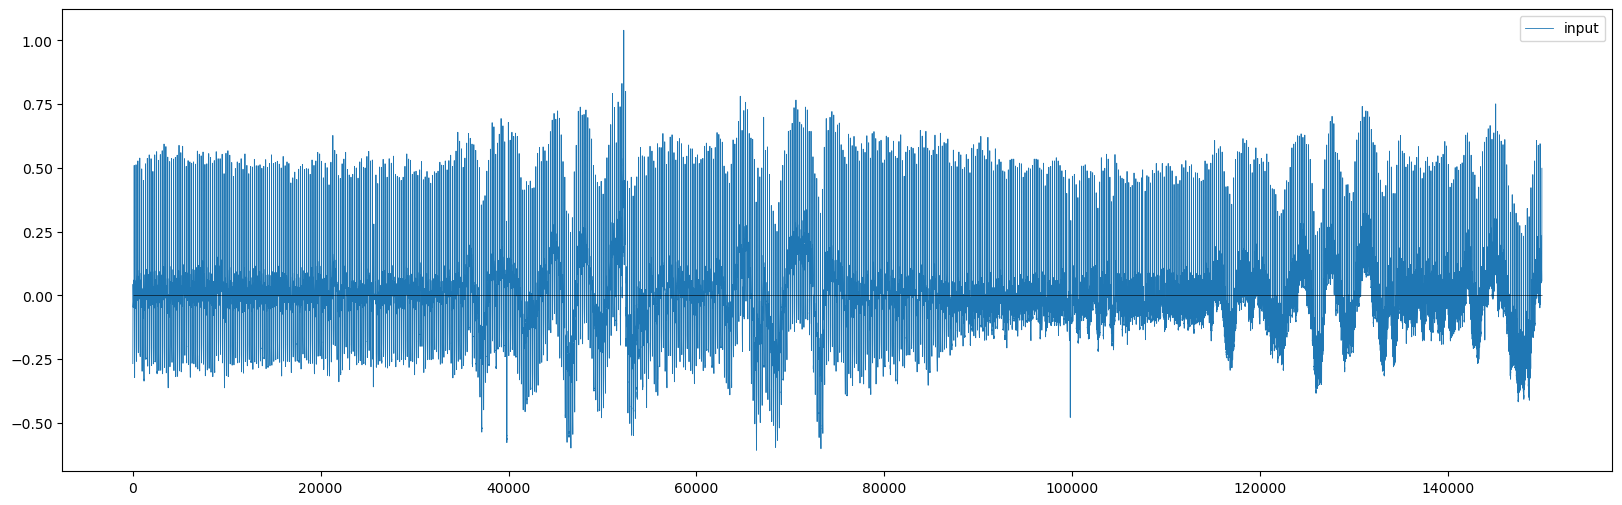

In [52]:
plt.figure(figsize=(20,6))
plt.plot(scd_segments['30'][0], color='tab:blue', linewidth=0.6,label = 'input')
plt.hlines(0,0,150000,color='black', linewidth=0.4)
plt.legend()
plt.show()

In [54]:
downsampled = resample_ecg(scd_segments['30'][0], 250, 128)

In [56]:
downsampled.shape

(76800,)

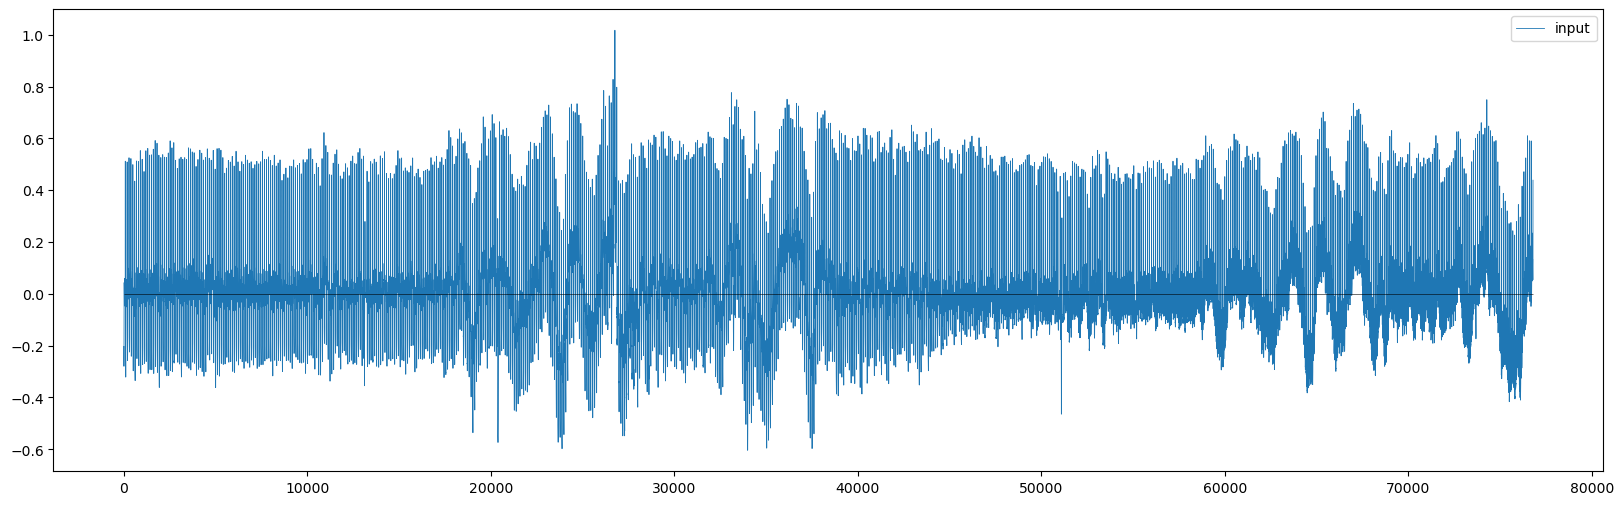

In [58]:
plt.figure(figsize=(20,6))
plt.plot(downsampled, color='tab:blue', linewidth=0.6,label = 'input')
plt.hlines(0,0,76800,color='black', linewidth=0.4)
plt.legend()
plt.show()

In [60]:
filtered = filter_signal(downsampled)
filtered.shape

(76800,)

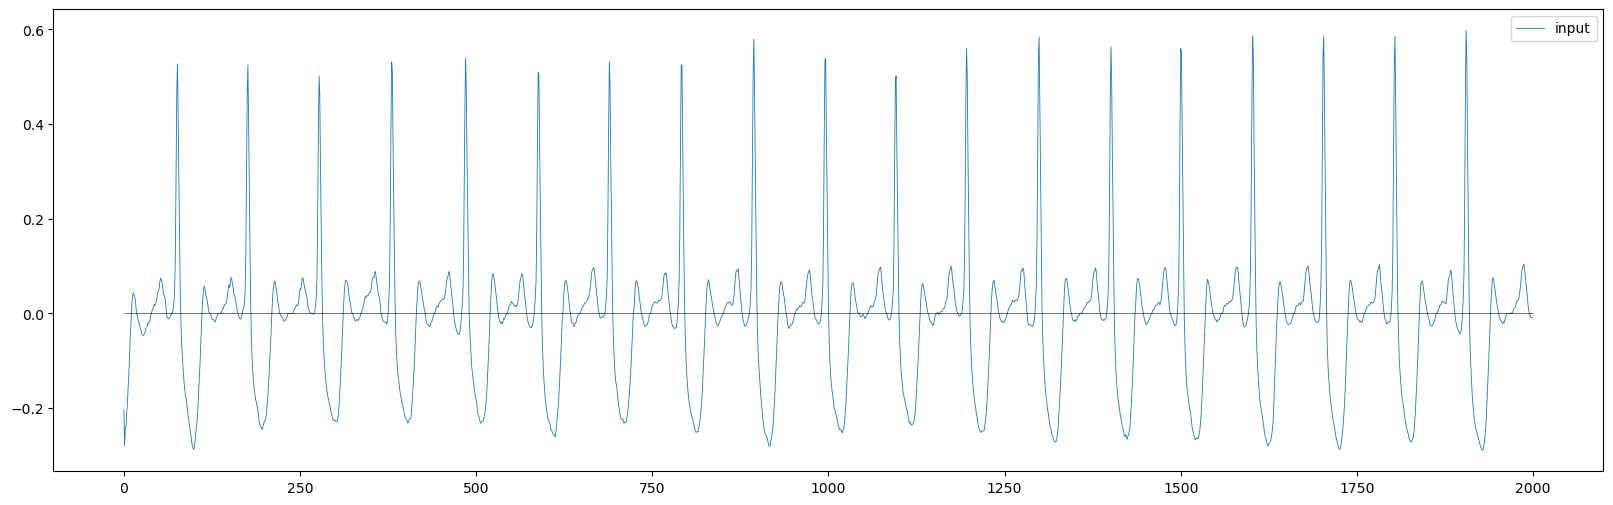

In [64]:
plt.figure(figsize=(20,6))
plt.plot(filtered[:2000], color='tab:blue', linewidth=0.6,label = 'input')
plt.hlines(0,0,2000,color='black', linewidth=0.4)
plt.legend()
plt.show()

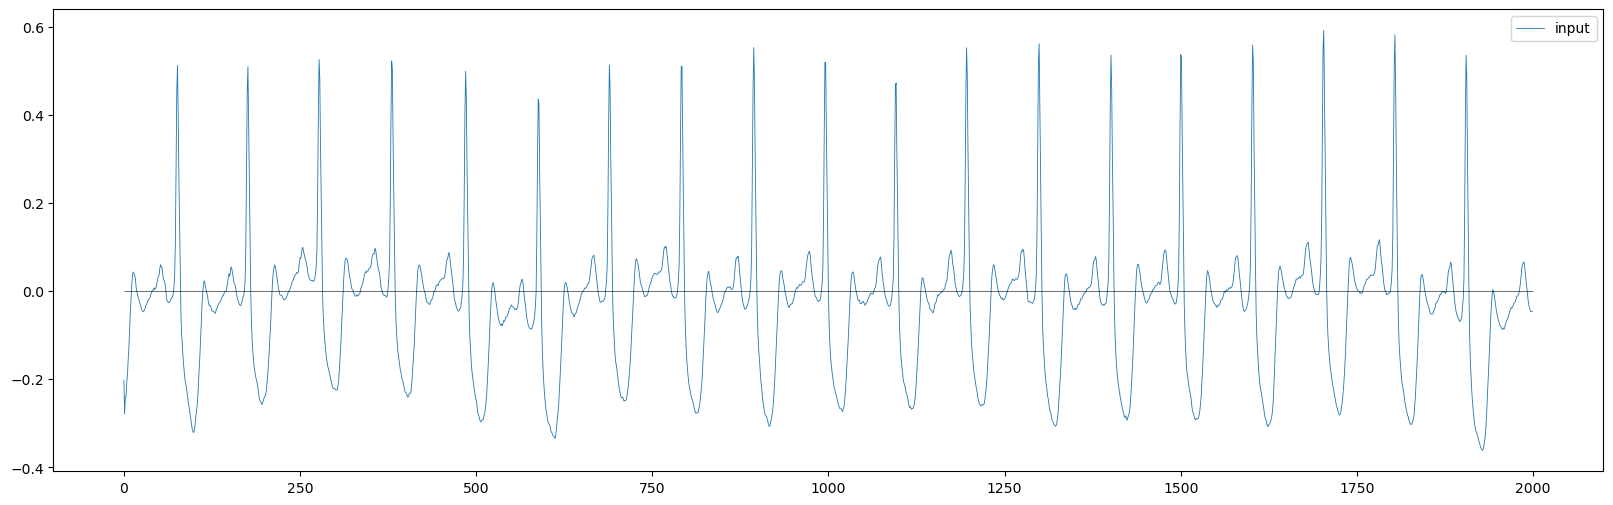

In [66]:
plt.figure(figsize=(20,6))
plt.plot(downsampled[:2000], color='tab:blue', linewidth=0.6,label = 'input')
plt.hlines(0,0,2000,color='black', linewidth=0.4)
plt.legend()
plt.show()

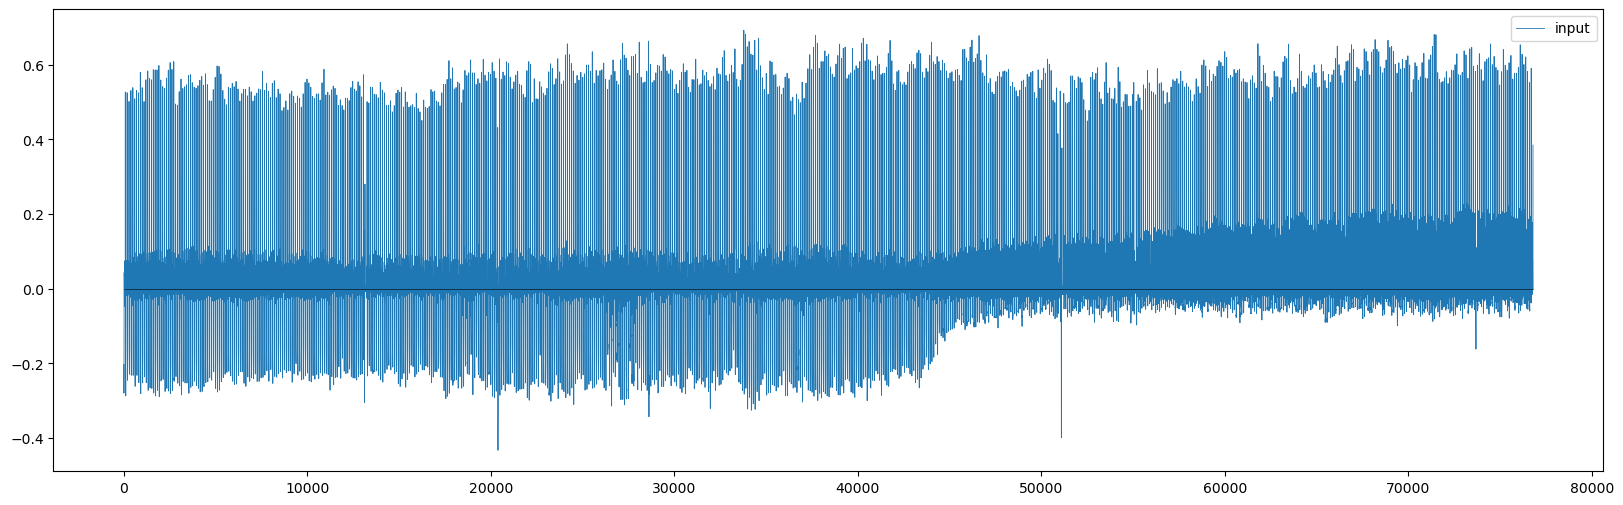

In [68]:
plt.figure(figsize=(20,6))
plt.plot(filtered, color='tab:blue', linewidth=0.6,label = 'input')
plt.hlines(0,0,76800,color='black', linewidth=0.4)
plt.legend()
plt.show()

In [84]:
denoised_signal = denoise_signal(filtered, 'sym20', 8, 0 , 5)

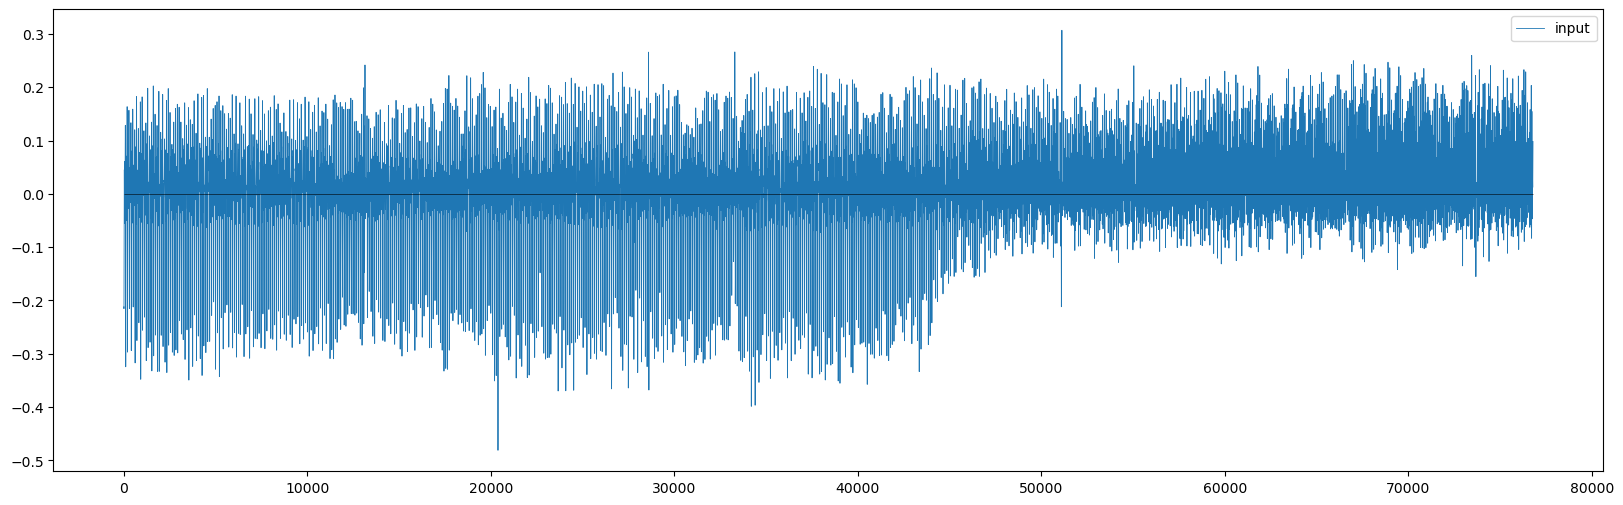

In [86]:
plt.figure(figsize=(20,6))
plt.plot(denoised_signal, color='tab:blue', linewidth=0.6,label = 'input')
plt.hlines(0,0,76800,color='black', linewidth=0.4)
plt.legend()
plt.show()

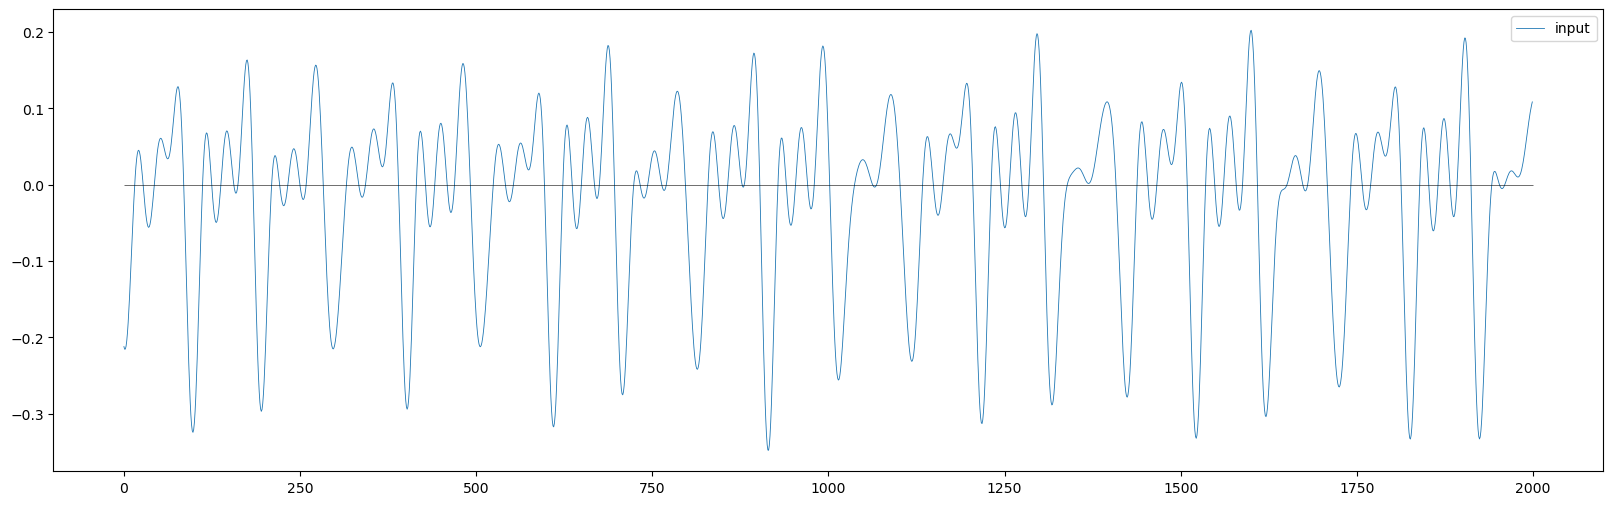

In [87]:
plt.figure(figsize=(20,6))
plt.plot(denoised_signal[:2000], color='tab:blue', linewidth=0.6,label = 'input')
plt.hlines(0,0,2000,color='black', linewidth=0.4)
plt.legend()
plt.show()